# Лабораторная работа №1: Изучение возможности библиотек Python для решения задач цифровой обработки сигналов

Выполнил студент группы 9383 Орлов Даниил, вариант 14.

### Цель работы:

Изучить возможности библиотек Python для решения задач цифровой обработки сигналов.

### Задачи лабораторной работы:

1. Освоить Jupyter Notebook.
2. Выполнить загрузку аудио сигнала и построить огибающую (график).
3. Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный сигнал.
4. Детектор сигнал/шум. Получить сигнал после детектирования.
5. Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.
6. Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.

### Построение огибающей

Имеется сигнал $x(i), i = 0, 1, ..., N - 1$. Хотим построить огибоющую $y(j), j = 0, 1, ..., n-1$. Пусть $ m = \begin{bmatrix} \frac{N}{n} \end{bmatrix}$ — число точек в интервале усреднения. Тогда <center>$y(j) = \frac{1}{m}\sum\limits_{k = mj}^{mj+m-1} \left | x(k) \right |$

In [67]:
import wave
#открываем файл с сигналом
sound = wave.open('C:/Users/odani/matpac/03-01-05-01-02-01-14_A14.wav', 'r')

import matplotlib.pyplot as plt
import numpy as np

data = sound.readframes(-1)
data = np.frombuffer(data, dtype=np.int16)


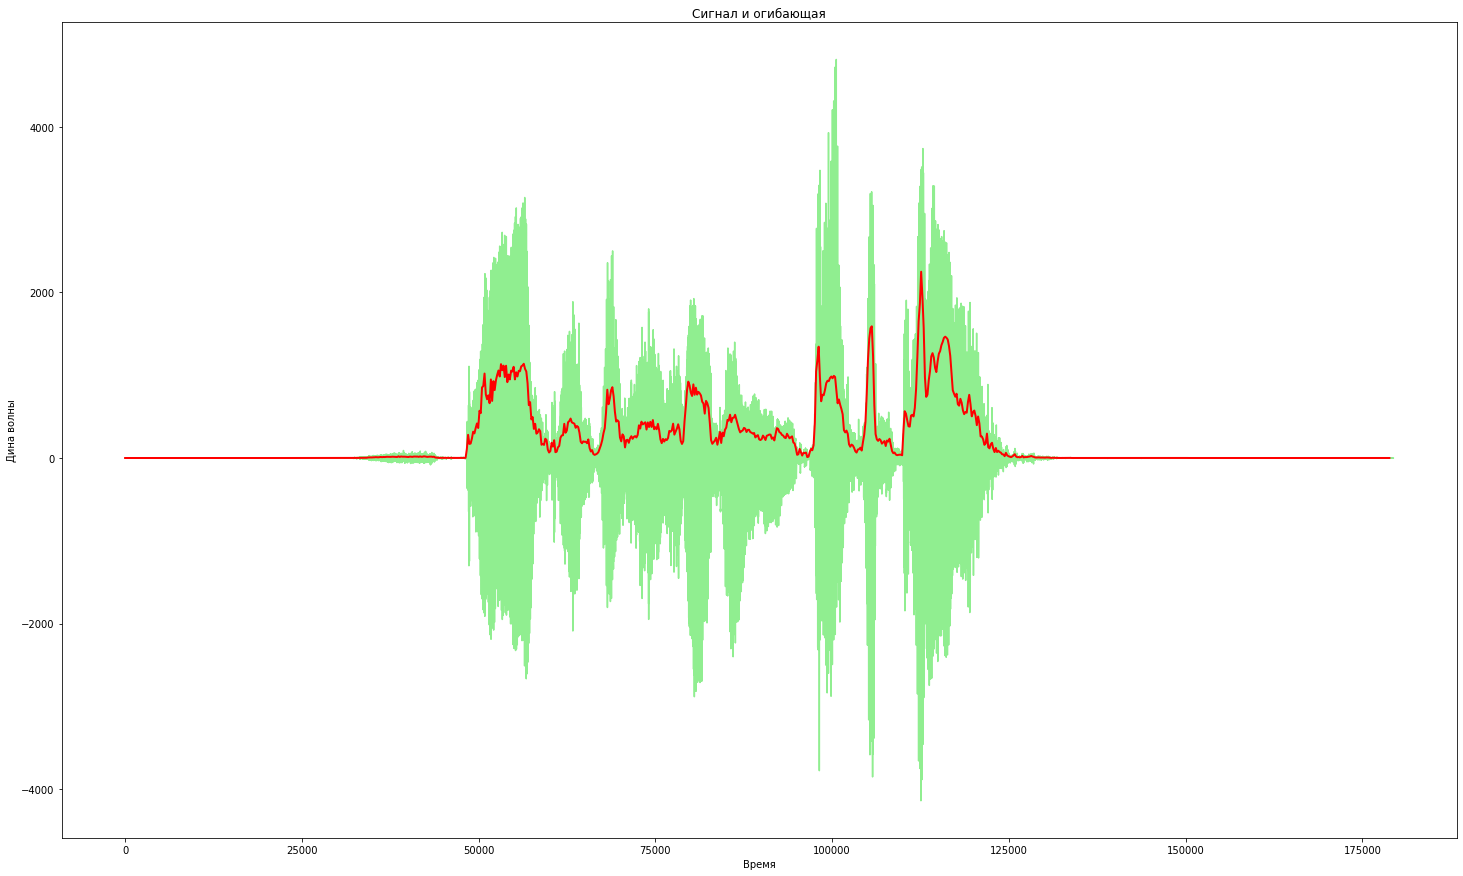

In [68]:
n = 1000
m = len(data) // n #число точек в интервале усреднения
x = [i for i in range(0, len(data), m)]
x = x[0:n]
yi = []
for j in range(n): #вычисление огибающей y(i) по формуле
    sum = 0
    for k in range(m * j, m * j + m - 1):
        sum += abs(data[k])
    sum /= m
    yi.append(sum)

plt.rcParams["figure.figsize"]= 25, 15 
plt.title("Сигнал и огибающая")
plt.plot(data, color = 'lightgreen')
plt.plot(x, yi, linewidth = 2, color = 'red')
plt.xlabel("Время")
plt.ylabel("Дина волны")
plt.show()

Зеленым цветов обозначен исходный сигнал, красным — огибающая.

### Фильтрация

Фильтрация полосовым фильтром. Пусть $F_{d}$ - частота дискретизации, частота среза - $F_{s}$. Порядок фильтра - $m$. Тогда вычисляем $wn = 2\frac{F_{s}}{F_{d}}$

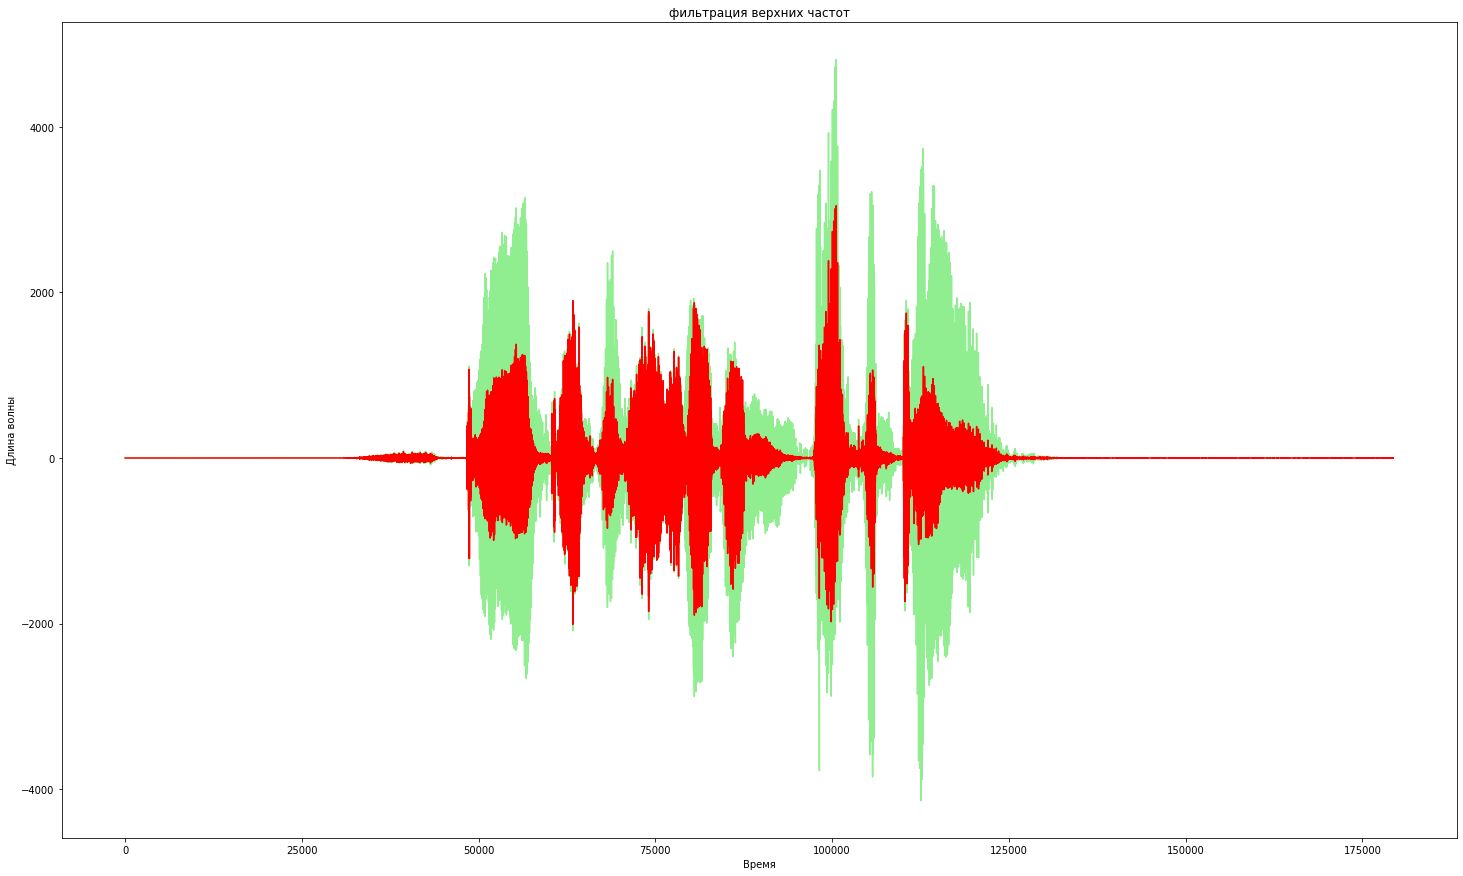

In [69]:
from scipy import signal
from scipy.io import wavfile

(nChannels, dataWidth, dataRate, nFrames, compType, compName) = sound.getparams()

m = 1 #порядок фильтра
Fs = 1500
wn = 2 * Fs / dataRate #вычисление wn, где dataRate - частота дискретизации, Fs - частота среза

b, a = signal.butter(m,wn,'highpass')
filt_data = signal.filtfilt(b, a, data)

plt.title('фильтрация верхних частот')
plt.plot(data, color = 'lightgreen')
plt.plot(filt_data, color= 'red')
plt.xlabel("Время")
plt.ylabel("Длина волны")
plt.show()


wavfile.write("filtered.wav", dataRate, filt_data.astype(np.int16))

Зеленым цветом обозначен исходный сигнал, красным — фильтрованный сигнал.

### Амплитудный детектор сигнал/шум

Определяем среднее сигнала по амплитуде(без учета знака): <center>$mid = \frac{1}{N}\sum\limits_{k=0}^{N-1}|x(k)|$

Определяем порог детектора — $Th = \alpha * mid$, где $0 < \alpha < 1$ подбирается экспериментально. Задаем величину "провала"(в отсчетах) — $k$. Обозначим $y(i)$ — сигнал после детектирования.

1. Событие "начало сигнала". Если $x(i)$ в течение $k$ отсчетов превышает порог, $y(i) = x(i)$.
2. Событие "окончание сигнала". Если $x(i)$ в течение $k$ отсчетов меньше порога, $y(i) = 0$.

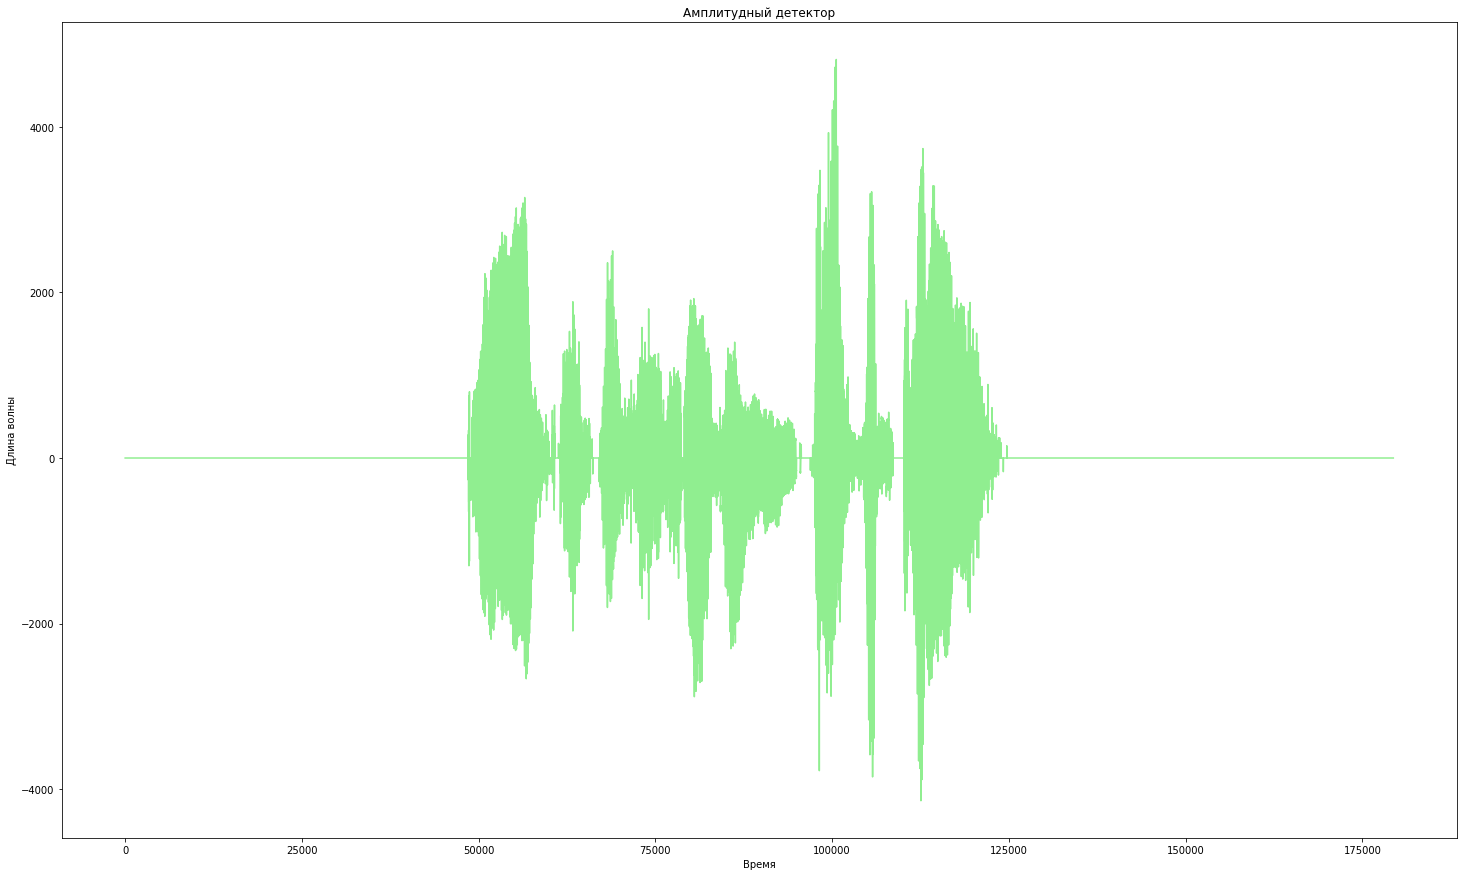

In [70]:
mid = 0
alpha = 0.7
for i in range(data.size): #определение порога детектора
    mid += abs(data[i])
mid = mid / data.size
Th = alpha * mid
k = 5
moreCounter = 0
lessCounter = 0
isSignal = False
yi = np.zeros(data.size)

for i in range(data.size): #детектирование начала и конца сигнала
    if abs(data[i]) > Th:
        moreCounter += 1
        lessCounter = 0
        if moreCounter >= k:
            isSignal = True
            yi[i] = data[i]
    else:
        lessCounter += 1
        moreCounter = 0
        if lessCounter >= k:
            isSignal = False

plt.title('Амплитудный детектор')            
plt.plot(yi, color = 'lightgreen')
plt.xlabel("Время")
plt.ylabel("Длина волны")
plt.show()
wavfile.write("detector.wav", dataRate, yi.astype(np.int16))            

### Эхо (простейший ревербератор)

Ревербератор реализован, как набор линий задержки. Число линий задержки $N_{L} > 8$. Каждая линия задержки имеет свой весовой коэффициент (задается пользователем): <center>$\alpha_{1} > \alpha_{2} > \dots > \alpha_{N_{L}}$.

$\cdot$ Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка.

$\cdot$ Желаемое соотношение между ”сухим”и обработанным сигналом задается коэффициентом применимости $\gamma$.

$\cdot$ Ревербератор может работать в двух режимах: ручной и с использованием готовой конфигурации (preset). Для ручного режима регулируется пользователем задается максимальная задержка $D_1$ , а величины остальных определяются автоматически через нее: <center>$D_i = D_1 2 ^\frac{1-i} {N_L}, i = 2, \dots,N_L$.
    
Для готовой конфигурации пользователь вручную задает последовательность <center>$D_1 > D_2 > \dots > D_{N_L}$.

Задайте максимальную задержку D1: 0.1


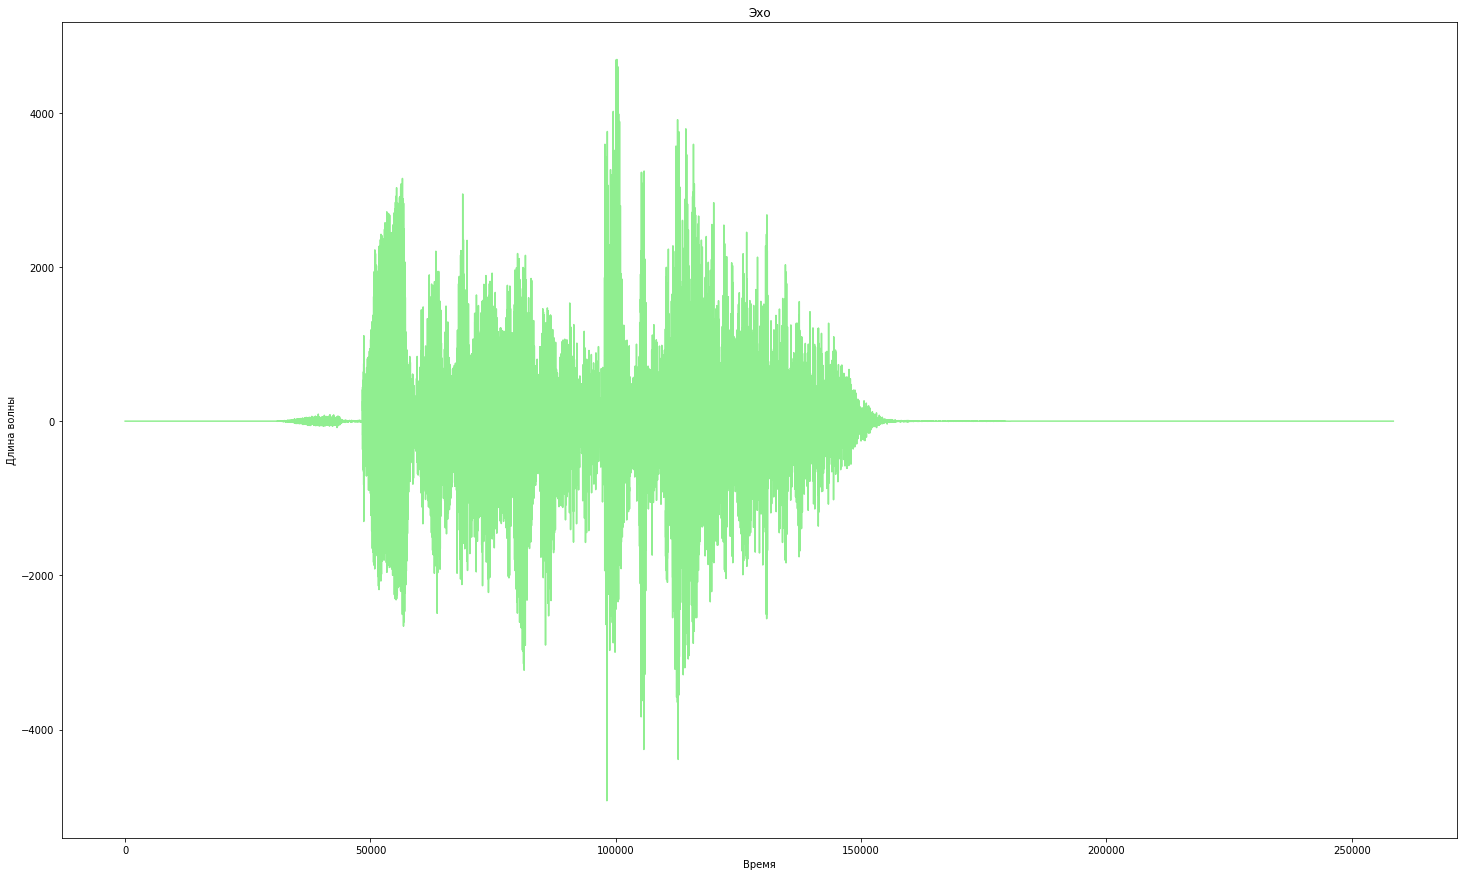

In [71]:
gamma = 0.7
alpha = [1 - i/10 for i in range(9)]
D1 = float(input('Задайте максимальную задержку D1: '))
Di = np.zeros(8)
Di[0] = D1
for i in range(1, 8):
    Di[i] = D1 * 2 **((1-i)/8)
    
Fs = 1000   # ФНЧ
wn = 2 * Fs/dataRate
b, a = signal.butter(1, wn,'lowpass')

arr = []
for i in range(8):
    echo = alpha[i] * data 
    arr.append(echo)
    arr[i] = signal.filtfilt(b, a, arr[i])
    arr[i] = arr[i] * gamma

res = np.zeros(int((np.sum(Di) + len(data)/dataRate + 1) * dataRate))

for i in range(1,8):
    Di[i] += Di[i-1]
    for j in range(len(arr[i])):
        res[j + int(Di[i] * dataRate)] += arr[i][j]
        
for i in range(len(data)):
    res[i] += data[i]

    
plt.title('Эхо')   
plt.plot(res, color= 'lightgreen')
plt.xlabel("Время")
plt.ylabel("Длина волны")
plt.show()    
wavfile.write("echo.wav", dataRate, res.astype(np.int16))    

### Эффект "Distortion"

Обозначим входной сигнал и выходной сигналы, соответственно как $x(i)$ и $y(i)$, $i = 0, 1, ..., N-1$. Пользователь задает порог - $Th$ и максимальное значение сигнала $Max > Th$. Тогда: <center>$Y(i) = \left\{\begin{matrix}
 x(i), |x(i)| < Th\\ 
 Max * sign(x(i)), |x(i)| > Th
\end{matrix}\right.$

Задайте порог: 2100
Задайте максимальное значение сигнала: 4000


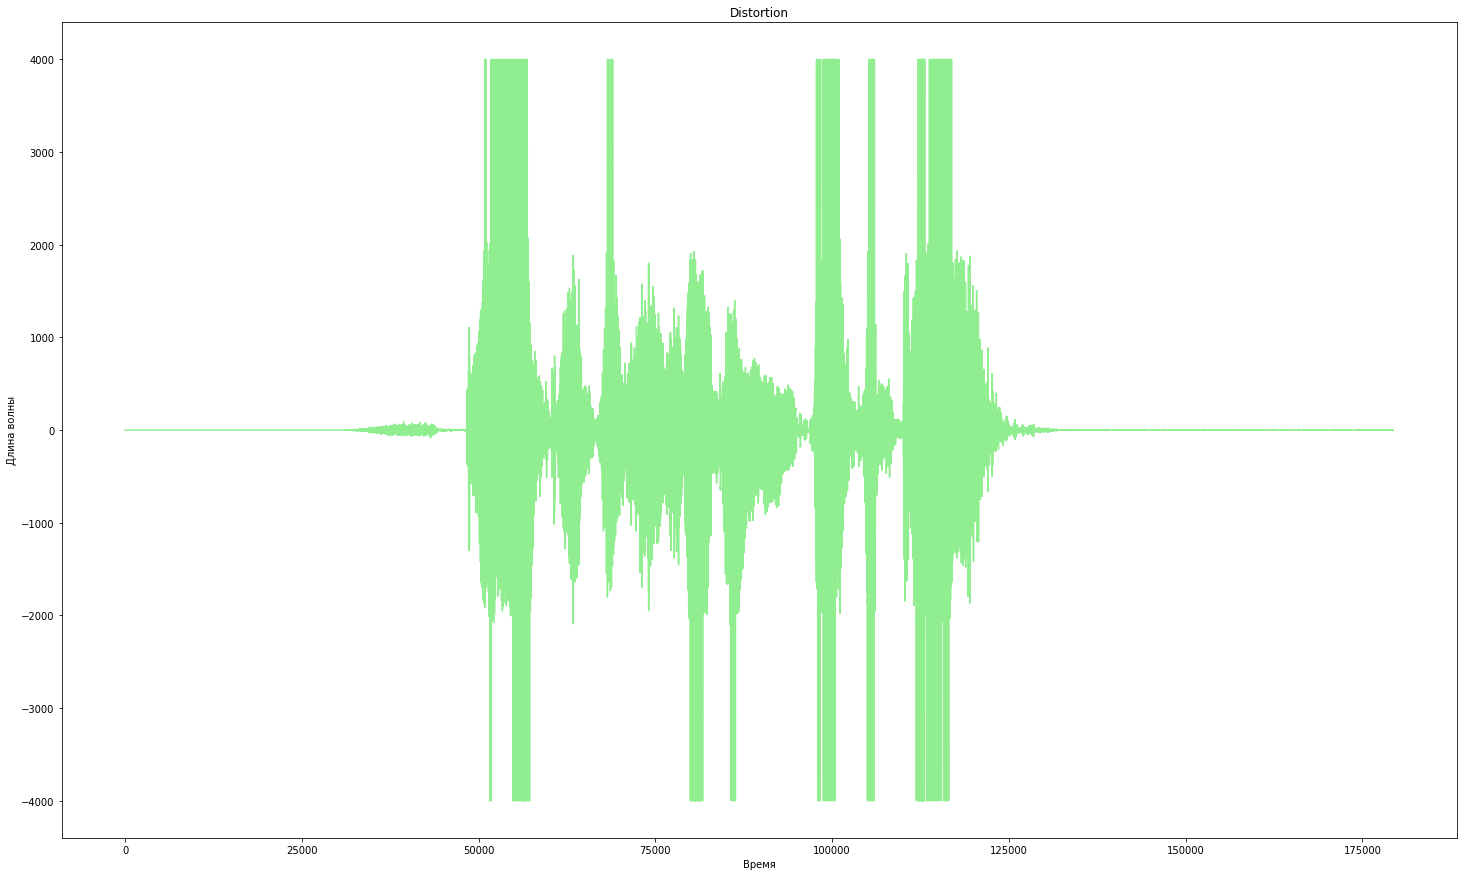

In [72]:
Th = int(input("Задайте порог: "))
max = int(input("Задайте максимальное значение сигнала: "))

distortion = np.zeros(data.size)
for i in range(data.size):
    if abs(data[i]) > Th:
        distortion[i] = np.sign(data[i]) * max
    else:
        distortion[i] = data[i]
        
plt.title('Distortion') 
plt.plot(distortion, color = 'lightgreen')
plt.xlabel("Время")
plt.ylabel("Длина волны")
plt.show()
wavfile.write("distortion.wav", dataRate, distortion.astype(np.int16))    

### Выводы:

Были изучены возможности библиотек Python для решения задач цифровой обработки сигналов.